<a href="https://colab.research.google.com/github/I-ULISES-I/Colabfiles/blob/main/PracticaReduccionNumerosidad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ==========================================================================
# 📝 Tarea: Reducción de la Numerosidad con CNN, ENN y K-medias usando SVM
# 📊 Dataset: Breast Cancer (Scikit-Learn)
# 👤 Autor/a: Ulises Hernández Rodríguez
# 📅 Fecha: 22/05/2025
# ==========================================================================

## 🔍 Descripción:
En este cuaderno aplicarás técnicas de reducción de la numerosidad (CNN, ENN, K-medias) al conjunto de datos Breast Cancer y analizarás su efecto en el rendimiento de un modelo SVM.

## ==========================================================================

## 1. Cargar librerías necesarias
Escribe aquí la importación de librerías: numpy, pandas, matplotlib, seaborn, sklearn (datasets, model_selection, preprocessing, metrics, svm, kmeans), etc.

En el caso de los códigos de ENN, CNN, estos  deberás tomarlos del cuaderno que contiene la teoría y ejemplos.

In [1]:
#1. Cargar librerías necesarias
#Importación de librerías.
from sklearn.datasets import load_breast_cancer
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.validation import check_X_y
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# --------------------------------------------------------------------------

## 2. Cargar y explorar el conjunto de datos Breast Cancer
- Cargar el dataset con sklearn.datasets.load_breast_cancer
- Explora las dimensiones, variables, y distribución de clases

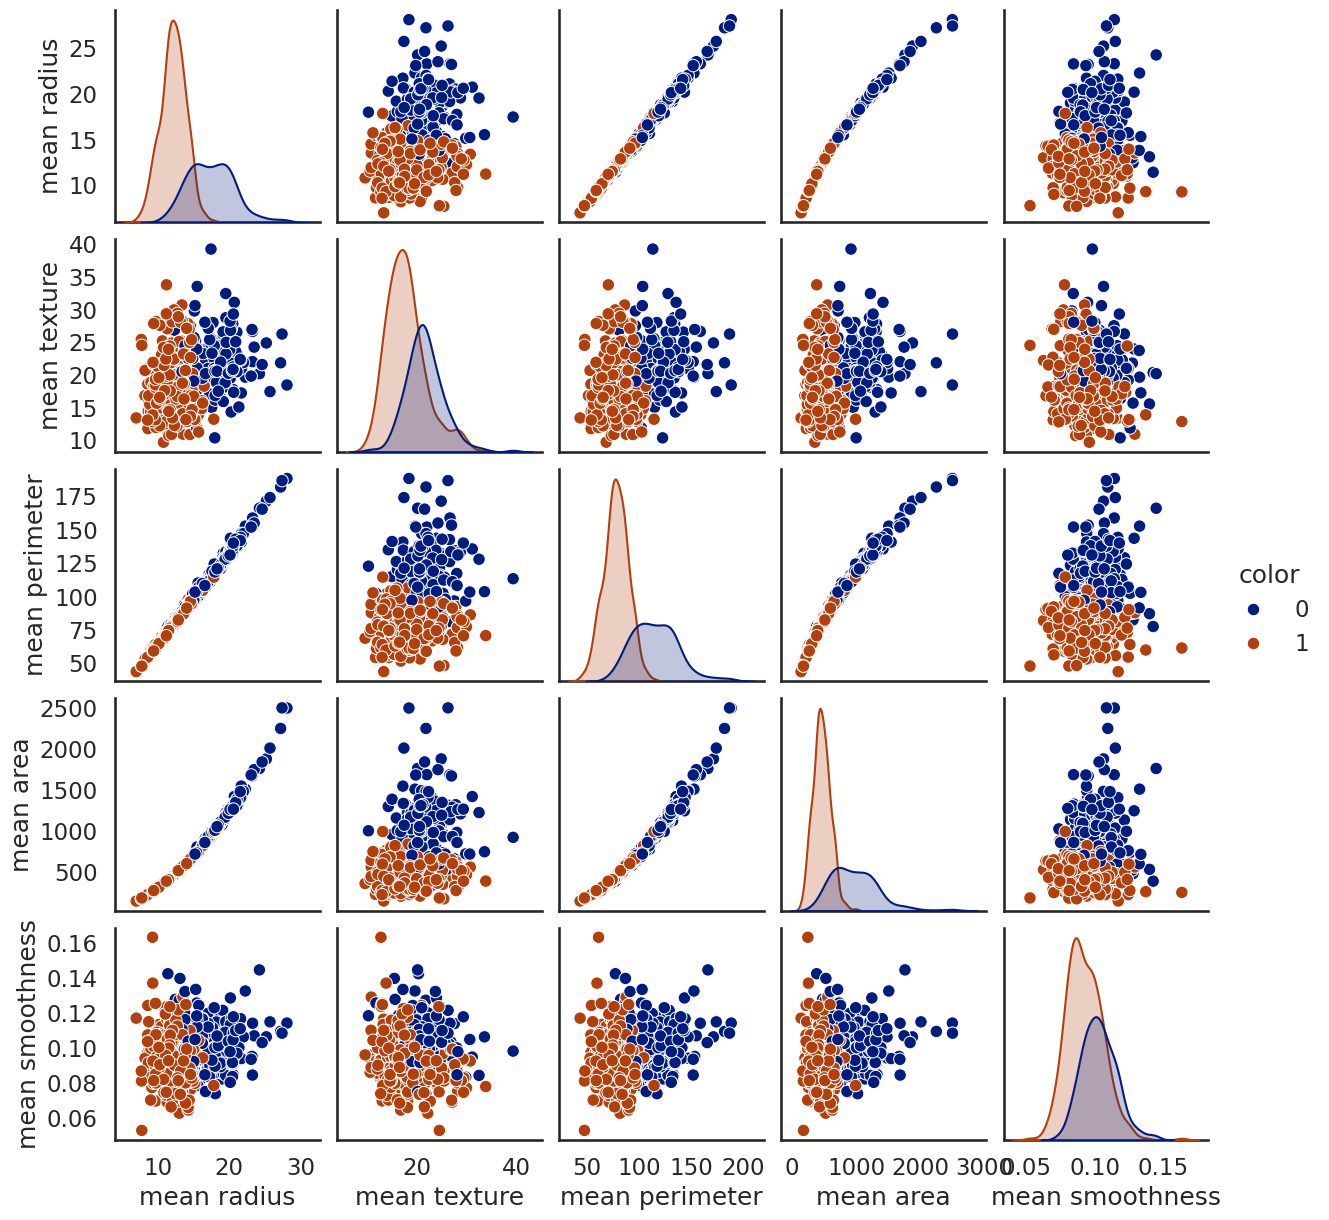

In [2]:
#2. Cargar y explorar el conjunto de datos Breast Cancer
#Carga de conjunto de datos.
data = load_breast_cancer()
X = data.data
y = data.target
target_names = data.target_names
breast_df = pd.DataFrame(X, columns=data.feature_names)
breast_df['color'] = y

#Creación y diseño de pairplot (solo 5 primeras características).
subset = breast_df.iloc[:, :5].copy()
subset['color'] = breast_df['color']
sns.set_context('talk')
sns.set_palette('dark')
sns.set_style('white')
sns.pairplot(subset, hue='color')
sns.reset_defaults()

# --------------------------------------------------------------------------

## 3. Preprocesamiento
 - Escalamiento de características (StandardScaler)
 - División del conjunto en entrenamiento y prueba
 - usar hold-out de 70% y 30%



In [3]:
# 3. Preprocesamiento
# División en entrenamiento (70%) y prueba (30%) - Hold-Out
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Escalamiento de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --------------------------------------------------------------------------

## 4. Aplicar técnica CNN (Condensed Nearest Neighbor)

- Aplicar CNN sobre el conjunto de entrenamiento
- Mostrar el tamaño del conjunto reducido



In [4]:
#4. Aplicar técnica CNN (Condensed Nearest Neighbor)
class CNN:
    """
    Condensed Nearest Neighbors (CNN) - versión adaptada para datos densos.

    Este algoritmo reduce el conjunto de entrenamiento reteniendo solo
    las instancias necesarias para preservar la capacidad de clasificación
    bajo la regla 1-NN (o k-NN si se ajusta n_neighbors).

    Basado en:
    P. E. Hart, The condensed nearest neighbor rule (1968).
    """

    def __init__(self, n_neighbors=1):
        self.n_neighbors = n_neighbors
        self.classifier = KNeighborsClassifier(n_neighbors=self.n_neighbors)
        self.sample_indices_ = []

    def select_data(self, X, y):
        # Validación de entrada: datos densos
        X, y = check_X_y(X, y, accept_sparse=False)

        idx_s = []  # índice de instancias seleccionadas
        classes = np.unique(y)
        self.classes_ = classes

        # Iniciar con una instancia aleatoria por clase
        for cur_class in classes:
            mask = np.where(y == cur_class)[0]
            choose_id = random.choice(mask)
            idx_s.append(choose_id)

        # Revisión aleatoria del resto de las instancias
        train_idx = list(range(len(y)))
        random.shuffle(train_idx)

        flag = True
        while flag:
            flag = False
            self.classifier.fit(X[idx_s], y[idx_s])
            for idx in train_idx:
                if idx not in idx_s:
                    x_i = X[idx].reshape(1, -1)
                    if self.classifier.predict(x_i) != [y[idx]]:
                        idx_s.append(idx)
                        self.classifier.fit(X[idx_s], y[idx_s])
                        flag = True

        self.X_ = X[idx_s]
        self.y_ = y[idx_s]
        self.sample_indices_ = sorted(idx_s)
        self.reduction_ = 1.0 - len(self.y_) / len(y)
        return self.X_, self.y_


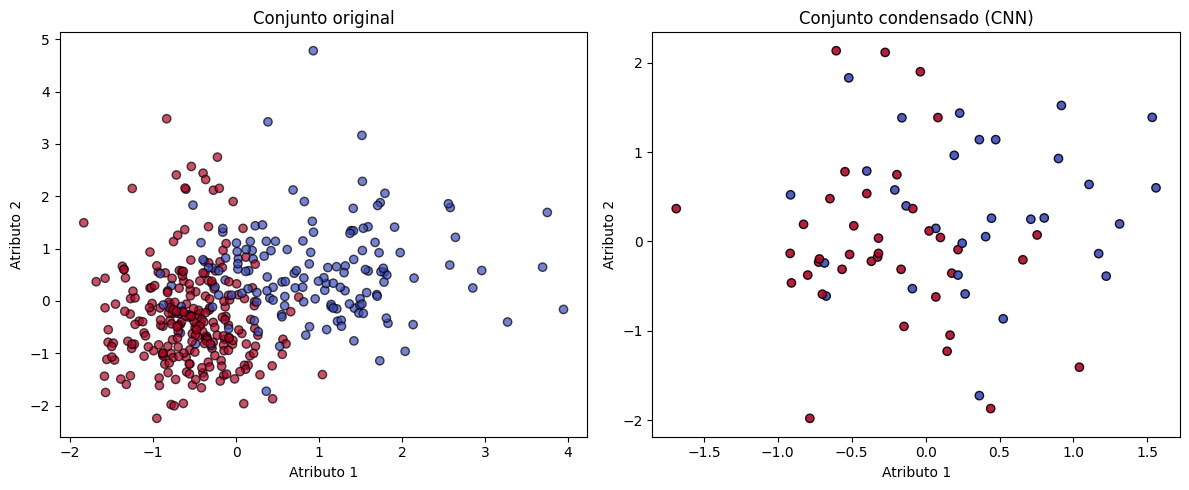

Instancias originales: 569
Instancias tras CNN:   69
Reducción: 82.66%


In [5]:


# Aplicar CNN
cnn = CNN(n_neighbors=1)
X_cnn, y_cnn = cnn.select_data(X_train_scaled, y_train)

# Visualización
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, cmap='coolwarm', edgecolor='k', alpha=0.7)
plt.title("Conjunto original")
plt.xlabel("Atributo 1")
plt.ylabel("Atributo 2")

plt.subplot(1, 2, 2)
plt.scatter(X_cnn[:, 0], X_cnn[:, 1], c=y_cnn, cmap='coolwarm', edgecolor='k', alpha=0.9)
plt.title("Conjunto condensado (CNN)")
plt.xlabel("Atributo 1")
plt.ylabel("Atributo 2")

plt.tight_layout()
plt.show()

print(f"Instancias originales: {len(y)}")
print(f"Instancias tras CNN:   {len(y_cnn)}")
print(f"Reducción: {100 * cnn.reduction_:.2f}%")

 --------------------------------------------------------------------------

## 5. Aplicar técnica ENN (Edited Nearest Neighbor)

- Aplicar ENN sobre el conjunto de entrenamiento
- Mostrar el tamaño del conjunto reducido



In [6]:
# 5. Aplicar técnica ENN (Edited Nearest Neighbor)
class ENN:
    def __init__(self, n_neighbors=3):
        self.n_neighbors = n_neighbors
        self.classifier = KNeighborsClassifier(n_neighbors=self.n_neighbors)
        self.sample_indices_ = []

    def fit(self, X, y):
        # Validación inicial
        X, y = check_X_y(X, y, accept_sparse=False)

        mask = np.ones(len(y), dtype=bool)
        tmp_m = np.ones(len(y), dtype=bool)

        indices = list(range(len(y)))
        random.shuffle(indices)

        for i in indices:
            tmp_m[i] = False
            self.classifier.fit(X[tmp_m], y[tmp_m])
            x_i = X[i].reshape(1, -1)
            y_pred = self.classifier.predict(x_i)
            if y_pred[0] != y[i]:
                mask[i] = False
            tmp_m[i] = True

        self.X_ = X[mask]
        self.y_ = y[mask]
        self.sample_indices_ = np.where(mask)[0]
        self.reduction_ = 1 - len(self.y_) / len(y)
        return self


Original: 569 muestras
Limpio:   383 muestras


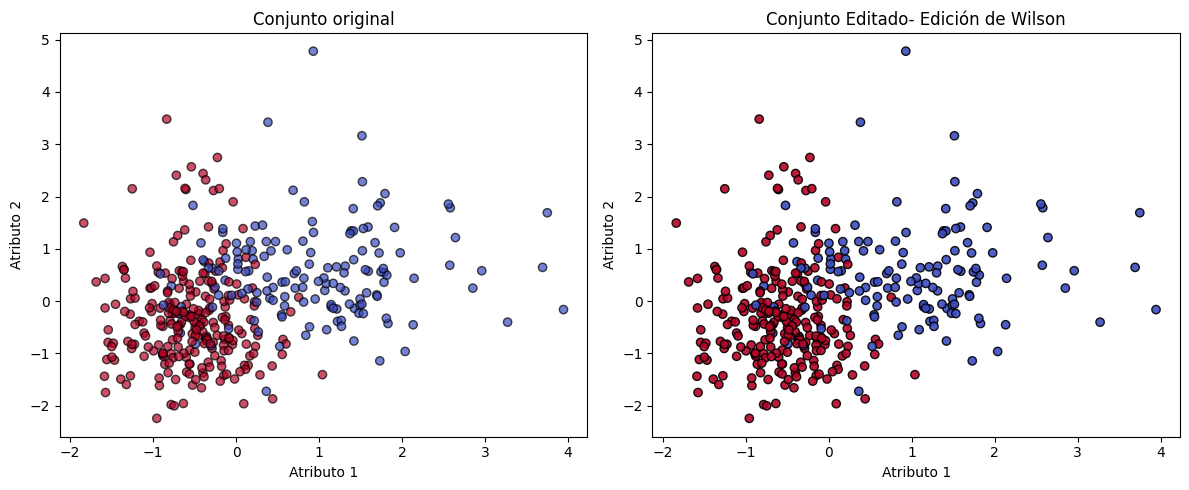

In [7]:
# Aplicar ENN
selector = ENN(n_neighbors=5)
selector.fit(X_train_scaled, y_train)

# Seleccionar subconjunto
idx = selector.sample_indices_
X_clean, y_clean = X_train_scaled[idx], y_train[idx]

print(f"Original: {len(y)} muestras")
print(f"Limpio:   {len(y_clean)} muestras")


# Visualización
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, cmap='coolwarm', edgecolor='k', alpha=0.7)
plt.title("Conjunto original")
plt.xlabel("Atributo 1")
plt.ylabel("Atributo 2")

plt.subplot(1, 2, 2)
plt.scatter(X_clean[:, 0], X_clean[:, 1], c=y_clean, cmap='coolwarm', edgecolor='k', alpha=0.9)
plt.title("Conjunto Editado- Edición de Wilson")
plt.xlabel("Atributo 1")
plt.ylabel("Atributo 2")

plt.tight_layout()
plt.show()




# --------------------------------------------------------------------------

## 6. Aplicar reducción mediante K-medias
- Realizar agrupamiento por clase y representar cada grupo con su centroide. Elige la mitad de los elementos de cada clase como el valor del número de centroides
- Generar un nuevo conjunto reducido con los centroides como prototipos



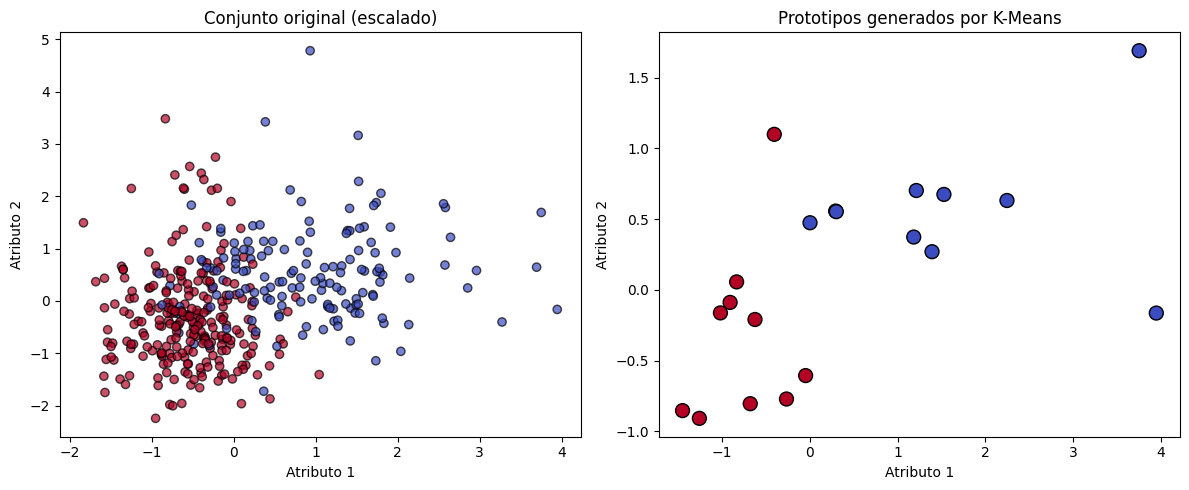

In [8]:
# 6. Aplicar reducción mediante K-medias
# Aquí puedes modificar el número de instancias por clase
# 3. Número de prototipos por clase
prototypes_per_class = 10
classes = np.unique(y_train)

# 4. Aplicar KMeans por clase
prototypes = []
labels = []

for c in classes:
    # Subconjunto de la clase actual
    class_data = X_train_scaled[y_train == c]

    # KMeans sobre los datos de la clase
    kmeans = KMeans(n_clusters=prototypes_per_class, random_state=42)
    kmeans.fit(class_data)

    # Guardar prototipos y sus etiquetas
    prototypes.append(kmeans.cluster_centers_)
    labels.extend([c] * prototypes_per_class)

# 5. Concatenar resultados
X_proto = np.vstack(prototypes)
y_proto = np.array(labels)

# 6. Visualización
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Conjunto original
axes[0].scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, cmap='coolwarm', edgecolor='k', alpha=0.7)
axes[0].set_title("Conjunto original (escalado)")
axes[0].set_xlabel("Atributo 1")
axes[0].set_ylabel("Atributo 2")

# Prototipos generados
axes[1].scatter(X_proto[:, 0], X_proto[:, 1], c=y_proto, cmap='coolwarm', edgecolor='k', s=100)
axes[1].set_title("Prototipos generados por K-Means")
axes[1].set_xlabel("Atributo 1")
axes[1].set_ylabel("Atributo 2")

plt.tight_layout()
plt.show()


 --------------------------------------------------------------------------

##7. Entrenar SVM sobre cada conjunto reducido
- Entrenar un modelo SVM (SVC) sobre:
 * los datos originales
 * datos reducidos con CNN
 * datos reducidos con ENN
 * datos reducidos con K-medias
- Evaluar cada modelo con accuracy, F1-score



In [9]:
#7. Entrenar SVM sobre cada conjunto reducido
# Entrenar el modelo SVC
svc_model_original = SVC()
svc_model_original.fit(X_train_scaled, y_train)
svc_model_cnn = SVC()
svc_model_cnn.fit(X_cnn, y_cnn)
svc_model_enn = SVC()
svc_model_enn.fit(X_clean, y_clean)
svc_model_kmeans = SVC()
svc_model_kmeans.fit(X_proto, y_proto)

# Hacer predicciones
y_pred = svc_model_original.predict(X_test_scaled)
y_pred_cnn = svc_model_cnn.predict(X_test_scaled)
y_pred_enn = svc_model_enn.predict(X_test_scaled)
y_pred_kmeans = svc_model_kmeans.predict(X_test_scaled)

# Evaluar el modelo
print("\nReporte de clasificación Original:\n", classification_report(y_test, y_pred))
print("\nReporte de clasificación CNN:\n", classification_report(y_test, y_pred_cnn))
print("\nReporte de clasificación ENN:\n", classification_report(y_test, y_pred_enn))
print("\nReporte de clasificación K-Medias:\n", classification_report(y_test, y_pred_kmeans))


Reporte de clasificación Original:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97        63
           1       0.98      0.98      0.98       108

    accuracy                           0.98       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171


Reporte de clasificación CNN:
               precision    recall  f1-score   support

           0       0.94      0.95      0.94        63
           1       0.97      0.96      0.97       108

    accuracy                           0.96       171
   macro avg       0.95      0.96      0.96       171
weighted avg       0.96      0.96      0.96       171


Reporte de clasificación ENN:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        63
           1       0.97      0.97      0.97       108

    accuracy                           0.96       171
   macro avg       0.96    

# --------------------------------------------------------------------------

## 📊 8. Comparar los resultados y reflexión final
- Comparar las métricas de rendimiento obtenidas con cada técnica
- Escribe tus conclusiones sobre el impacto de la reducción de la numerosidad
- ¿Cuál técnica funcionó mejor? La del modelo originial, sin reducción de numerosidad. ¿Qué ventajas y desventajas observaste? Aplicar técnicas de reducción de numerosidad pueden ser valiosas cuando se necesita mejorar la eficiencia computacional, pero la precisión del modelo podría disminuir.

Es importante tener cuidado al momento de hacer uso de técnicas de reducción de numerosidad, ya que si estas no se controlan adecuadamente, podría terminar eliminando datos valiosos del conjunto. Esto puede afectar la capacidad de los modelos para aprender correctamente, especialmente en clases minoritarias.

